# Importing packages

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf

# Yang-Zhang Volatility

Based on https://www.jstor.org/stable/10.1086/209650?seq=2#page_scan_tab_contents
- Assume logrithm of security price can be modeled as a geometric Brownian motion with two undetermined parameters, volatility $\sigma$ and drift $\mu$
- Estimate volatility based on open, close, high and low
- Yang and Zhang's proposed variance estimator is independent of both the drift motion and opening jumps
- Yang-Zhang volatility accounts for opening jumps which the previous volatility estimators could not

In [58]:
tickers = 'SPY'
period = 'max'
interval = '1d'
prices = yf.download(tickers = tickers, period=period, interval=interval)
prices.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.684093,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,24.859671,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,24.912338,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.175682,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.281021,531500


Yang and Zhang's minimum-variance unbiased variance estimator is defined as

\begin{align*}
    V &= V_O + kV_C + (1 - k) V_{RS}
\end{align*}

\begin{align*}
    V_O &= \frac{1}{n-1}\sum_{i=1}^n (o_i - \bar(o))^2 & & & V_C &= \frac{1}{n-1}\sum_{i=1}^n (c_i - \bar(c))^2 & & & V_{RS} &= \frac{1}{n} \sum_{i=1}^n \big(u_i(u_i - c_i) + d_i(d_i - c_i)\big)
\end{align*}

$k = k_0$ yields the minimum variance of the variance estimator
\begin{align*}
k = k_0 &\equiv \frac{\mathbb{E}\big((V_O+V_{RS})(V_{RS}-V_C)\big)}{\mathbb{E}\big((V_{RS}-V_C)^2\big)} \\
\Longrightarrow k_0 &= \frac{\alpha - 1}{\alpha + \frac{n+1}{n-1}} \\\\
\alpha &= \frac{\mathbb{E}\big((u(u-c)+d(d-c))^2\big)}{\sigma^4(1-f)^2}
\end{align*}

In [59]:
# Implementing Yang-Zhang variance
def variance_yang_zhang(open, high, low, close, f=None):
    n = len(close)
    o = np.log(open.iloc[1:] / close.shift(1).iloc[1:])
    u = np.log(high.iloc[1:] / open.iloc[1:]).values
    d = np.log(low.iloc[1:] / open.iloc[1:]).values
    c = np.log(close.iloc[1:] / open.iloc[1:]).values

    variance_rogers_satchell = np.mean(u * (u - c) + d * (d - c))
        
    if f is not None:
        alpha = np.mean((u * (u - c) + d * (d - c)) ** 2) / (np.var(c) ** 2 * (1 - f) ** 2)
    else:
        alpha = 1.34
    k0 = (alpha - 1) / (alpha + (n + 1) / (n - 1))
    
    variance_open = np.var(o)
    variance_close = np.var(c)

    return variance_open + k0 * variance_close + (1 - k0) * variance_rogers_satchell

In [60]:
# Calculating the rolling volatility
def rolling_volatility(df, window=5):
    dates = []
    vols = []
    for i in range(0, len(df) - window + 1):
        rolling_df = df.iloc[i:window+i]
        dates.append(rolling_df.index[-1])
        yangZhangVolatility = np.sqrt(variance_yang_zhang(rolling_df['Open'], rolling_df['High'], rolling_df['Low'], rolling_df['Close']))
        vols.append(yangZhangVolatility)
    return pd.DataFrame({'Date': dates, 'YangZhangVolatility': vols})

In [61]:
# Plotting the results
from datetime import datetime
from dateutil.relativedelta import relativedelta

cut_off_date = str(datetime.today().date() - relativedelta(years=5))

filtered_prices = prices[prices.index >= cut_off_date]
volatility = rolling_volatility(filtered_prices[['Open', 'High', 'Low', 'Close']], 5)
filtered_prices = filtered_prices.merge(volatility, how='left', left_on=filtered_prices.index, right_on=volatility['Date'])
filtered_prices = filtered_prices.set_index('key_0')[['Open', 'High', 'Low', 'Close', 'YangZhangVolatility']]


In [62]:
layout = go.Layout(title=f"{tickers} Close Price and Volatility",
                   yaxis=dict(title='Close Price'),
                   yaxis2=dict(title='Volatility',
                               overlaying='y',
                               side='right'))

candleSticks = go.Candlestick(x=filtered_prices.index,
                              open=filtered_prices['Open'],
                              high=filtered_prices['High'],
                              low=filtered_prices['Low'],
                              close=filtered_prices['Close'],
                              name='Prices',
                              yaxis='y1')

line = go.Scatter(x=filtered_prices.index, y=filtered_prices['YangZhangVolatility'], 
                  mode='lines', yaxis='y2', name='Yang-Zhang Volatilty', 
                  marker = {'color': 'orange'}, opacity=0.5)

data = [candleSticks, line]

fig = go.Figure(data=data, layout=layout)

fig.update_layout(xaxis_rangeslider_visible=False,
                  legend=dict(y=1.1, x=0.85),
                  autosize=False,
                  width=1500,
                  height=750)

fig.show()

Although the recent sell-off at the start of August 2024 created a very volatile market which was reflected on the jump of Yang-Zhang volatility on SPY from $0.010$ at the end of July to $0.024$, it was not as volatile as the market during COVID back in 2020 which had a peak in March 2020 with a volatility of $0.090$.

# GARCH

Plotting the returns

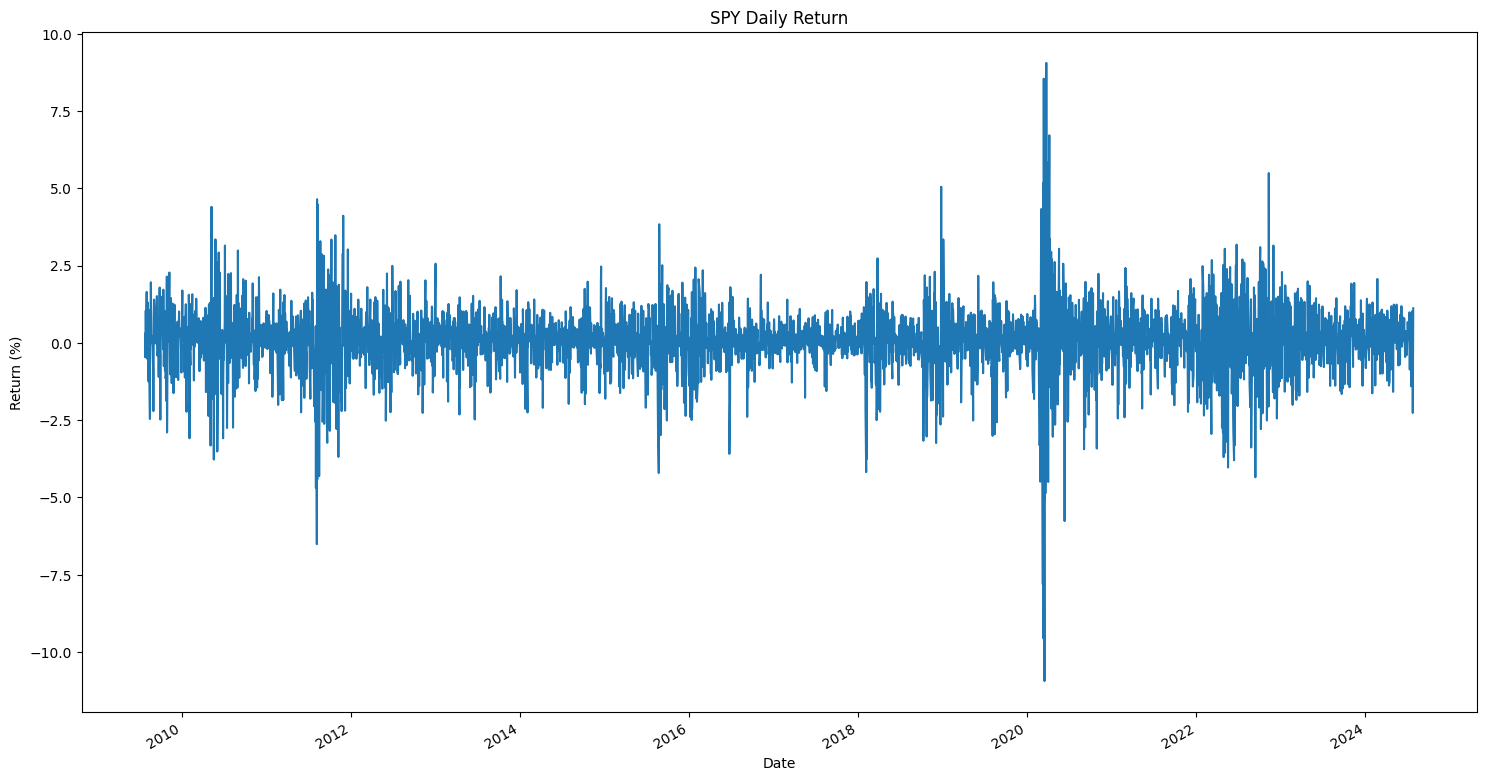

In [63]:
prices['Return'] = prices['Close'].pct_change() * 100
returns = prices['Return'].dropna()

train_end_date = '2024-07-26'
train_start_date = str(pd.to_datetime(train_end_date) - relativedelta(years=15))
returns_train = returns[(returns.index >= train_start_date) & (returns.index <= train_end_date)]

plt.figure(figsize=(18,10))
returns_train.plot(title=f"{tickers} Daily Return", ylabel='Return (%)')

plt.show()

ACF and PACF of returns since August 2019

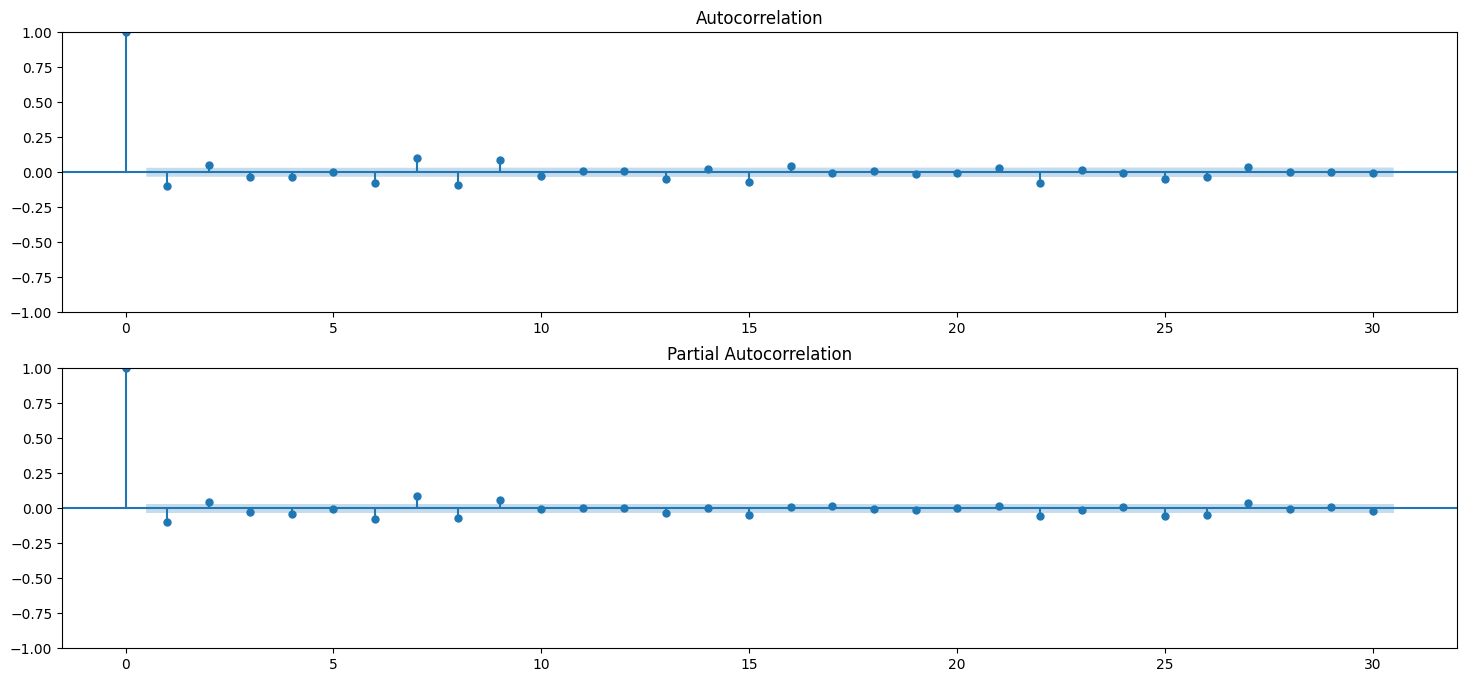

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(18,8))

plot_acf(returns_train, lags=30, ax=ax[0]);
plot_pacf(returns_train, lags=30, ax=ax[1]);

The plots on returns significant autocorrelation show at lag 1 and lag 2. This suggests that a $GARCH$ model could be suitable in modeling the volatility

Applying Ljung-Box test to assess whether GARCH is appropriate.

\begin{align*}
H_0&: \text{The returns are independently distributed (No autocorrelation)} \\
H_a&: \text{The returns are not independtly distributed}
\end{align*}

If $\text{p-value} \leq \alpha = 0.05$, then we reject $H_0$ claiming the returns are not independtly distributed, in which $GARCH$ model can be applied

In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox

alpha = 0.05

ljung_box = acorr_ljungbox(returns_train, lags=30)
ljung_box[ljung_box.lb_pvalue <= alpha]

,lb_stat,lb_pvalue
1,37.537148,8.968846e-10
2,47.299288,5.359078e-11
3,51.509313,3.810451e-11
4,56.187874,1.831305e-11
5,56.190631,7.424175e-11
6,80.276382,3.132723e-15
7,119.384394,1.029168e-22
8,149.651758,2.317733e-28
9,176.692499,2.483561e-33
10,178.808273,4.141354e-33


p-value is less than $\alpha$. Hence, we reject the $H_0$

We will compare $GARCH(1,1)$ and higher degree $GARCH(p,q)$ models where $p, q \gt 1$

$AR(1)$-$GARCH(1,1)$

In [66]:
from arch import arch_model

garch_model_11 = arch_model(returns_train, vol='GARCH', mean='ARX', lags=1, p=1, q=1)
garch_model_11.fit(disp='off').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                      GARCH   Log-Likelihood:               -4847.66
Distribution:                  Normal   AIC:                           9705.32
Method:            Maximum Likelihood   BIC:                           9736.50
                                        No. Observations:                 3775
Date:                Sun, Aug 11 2024   Df Residuals:                     3773
Time:                        16:02:37   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0870  1.257e-02      6.918  4.588e-12     [6.234e-02,  0.112]
Return[1]     -0.0423  1.779e-02     -2.379  1.737e-02 [-7.720e-02,-7.451e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0343  6.796e-03      5.051  4.405e-07 [2.100e-02,4.764e-02]
alpha[1]       0.1642  1.932e-02      8.497  1.941e-17     [  0.126,  0.202]
beta[1]        0.8071  1.883e-02     42.857      0.000     [  0.770,  0.844]
============================================================================

Covariance estimator: robust
"""

All coefficients of $AR(1)$-$GARCH(1,1)$ are significant on a significance level of $0.05$ yielding a log-likelihood of $-4851.31$

$AR(1)$-$GARCH(1,2)$

In [67]:
garch_model_12 = arch_model(returns_train, vol='GARCH', mean='ARX', p=1, q=2)
garch_model_12.fit(disp='off').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4851.31
Distribution:                  Normal   AIC:                           9712.63
Method:            Maximum Likelihood   BIC:                           9743.81
                                        No. Observations:                 3776
Date:                Sun, Aug 11 2024   Df Residuals:                     3775
Time:                        16:02:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0832  1.219e-02      6.825  8.781e-12 [5.930e-02,  0.107]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0345  7.176e-03      4.813  1.487e-06 [2.047e-02,4.860e-02]
alpha[1]       0.1639  2.401e-02      6.825  8.767e-12     [  0.117,  0.211]
beta[1]        0.8072      0.158      5.110  3.228e-07     [  0.498,  1.117]
beta[2]    1.3785e-15      0.140  9.814e-15      1.000     [ -0.275,  0.275]
============================================================================

Covariance estimator: robust
"""

The coefficient of the additional past squared returns, $\beta_2$, has p-value greater than a confidence level of $0.05$. Adding an additional $ARCH$ term also did not increase log-likelihood. Hence, $AR(1)$-$GARCH(1,1)$ is a better model than $AR(1)$-$GARCH(1,2)$

$AR(1)$-$GARCH(2,1)$

In [68]:
garch_model_21 = arch_model(returns_train, vol='GARCH', mean='ARX', lags=1, p=2, q=1)
garch_model_21.fit(disp='off').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                      GARCH   Log-Likelihood:               -4844.73
Distribution:                  Normal   AIC:                           9701.45
Method:            Maximum Likelihood   BIC:                           9738.87
                                        No. Observations:                 3775
Date:                Sun, Aug 11 2024   Df Residuals:                     3773
Time:                        16:02:37   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0858  1.243e-02      6.906  4.989e-12     [6.147e-02,  0.110]
Return[1]     -0.0406  1.752e-02     -2.316  2.058e-02 [-7.492e-02,-6.232e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0406  8.764e-03      4.636  3.547e-06 [2.346e-02,5.781e-02]
alpha[1]       0.1245  3.117e-02      3.993  6.537e-05   [6.336e-02,  0.186]
alpha[2]       0.0639  3.743e-02      1.706  8.796e-02  [-9.495e-03,  0.137]
beta[1]        0.7779  2.665e-02     29.194 2.337e-187     [  0.726,  0.830]
============================================================================

Covariance estimator: robust
"""

Similarly, the p-value of the coefficient of the additional past volatility, $0.0817$, is greater than a significance level of $0.05$. Hence, comparing $AR(1)$-$GARCH(1,1)$ and $AR(1)$-$GARCH(2,1)$, the former is still better.

# AR(1)-GARCH(1,1) Evaluation

In [69]:
garch_model = arch_model(returns_train, vol='GARCH', mean='ARX', lags=1, p=1, q=1)
fittedGARCH = garch_model.fit(disp='off')
resid = fittedGARCH.resid
fittedGARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                      GARCH   Log-Likelihood:               -4847.66
Distribution:                  Normal   AIC:                           9705.32
Method:            Maximum Likelihood   BIC:                           9736.50
                                        No. Observations:                 3775
Date:                Sun, Aug 11 2024   Df Residuals:                     3773
Time:                        16:02:37   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0870  1.257e-02      6.918  4.588e-12     [6.234e-02,  0.112]
Return[1]     -0.0423  1.779e-02     -2.379  1.737e-02 [-7.720e-02,-7.451e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0343  6.796e-03      5.051  4.405e-07 [2.100e-02,4.764e-02]
alpha[1]       0.1642  1.932e-02      8.497  1.941e-17     [  0.126,  0.202]
beta[1]        0.8071  1.883e-02     42.857      0.000     [  0.770,  0.844]
============================================================================

Covariance estimator: robust
"""

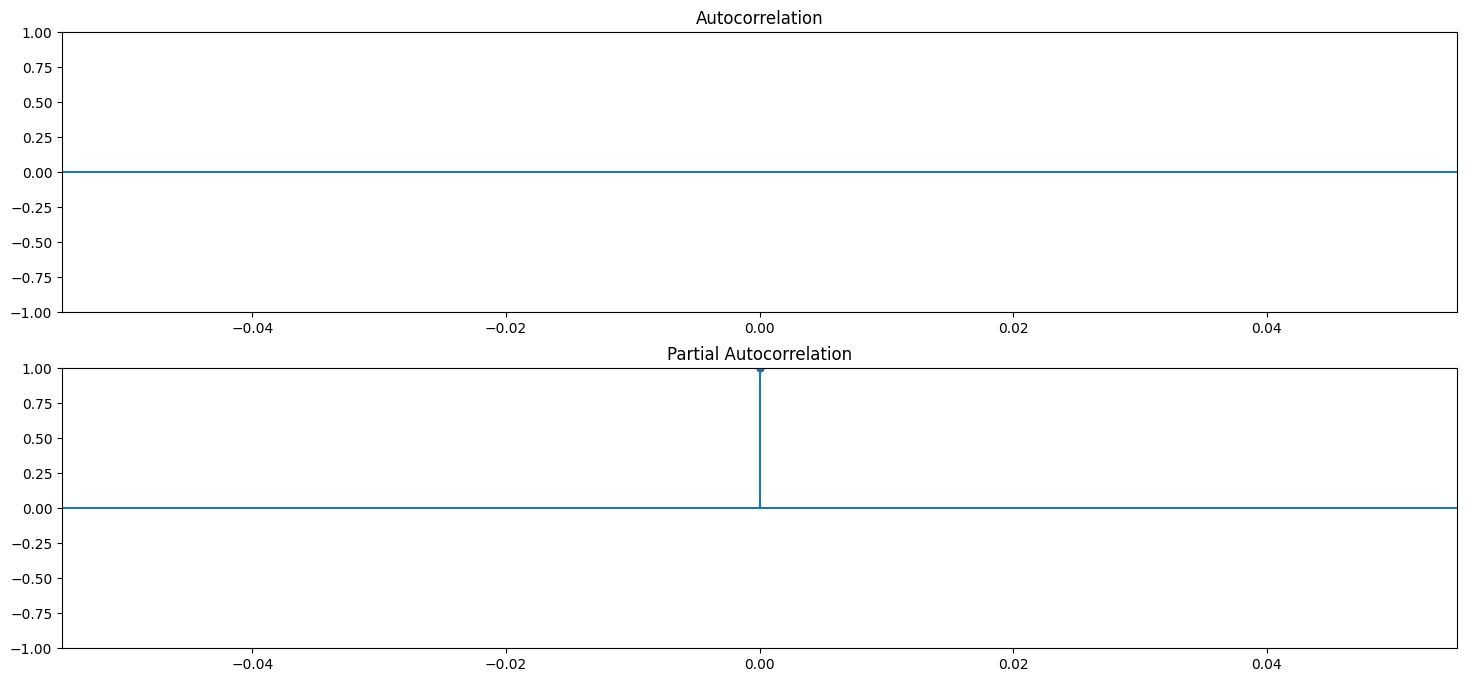

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))

plot_acf(resid, lags=30, ax=ax[0]);
plot_pacf(resid, lags=30, ax=ax[1]);

Fitting our $AR(1)$-$GARCH(1,1)$ model gives a non-autocorrelated residuals which means the fit was successful

Text(0.5, 1.0, 'Q-Q Plot of Residuals')

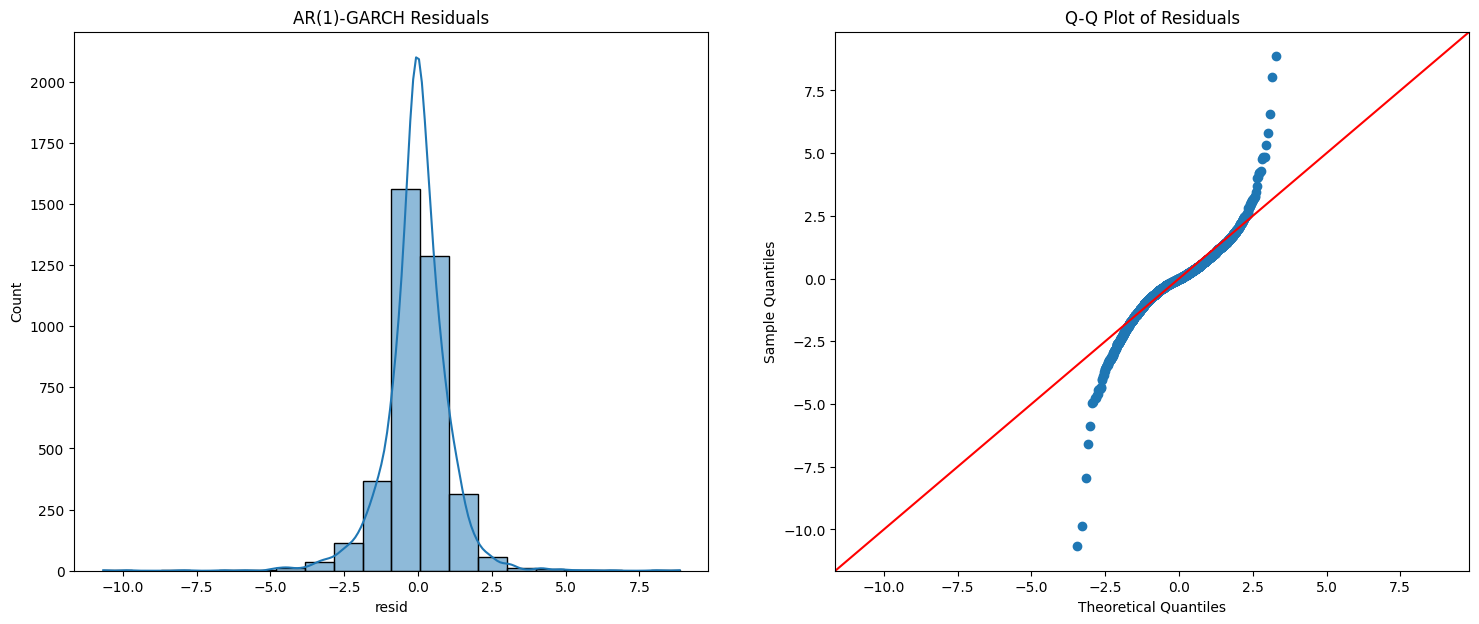

In [71]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(resid, kde=True, bins=20, ax=ax[0]);
ax[0].set_title('AR(1)-GARCH Residuals')
sm.qqplot(resid, line='45', ax=ax[1]);
ax[1].set_title('Q-Q Plot of Residuals')

The Q-Q plot shows that majority of the residuals lie around the 45-degree red line. This suggests that they are approxmiately normal distributed with heavy tails on both ends

Applying Ljung-Box test on the residuals

\begin{align*}
H_0&: \text{The residuals are independently distributed (No autocorrelation)} \\
H_a&: \text{The residuals are not independtly distributed}
\end{align*}

In [72]:
ljung_box = acorr_ljungbox(resid, lags=30)
ljung_box[ljung_box.lb_pvalue <= alpha]

,lb_stat,lb_pvalue


Ljung-Box test result shows that we failed to reject $H_0$. Hence, the residuals are not auto correlated.

The ACF/PACF of residuals and Ljung-Box test on residuals suggest that the $AR(1)$-$GARCH$ model is well fitted.

Let's forecast the next 5 trading days' volatilities

In [73]:
horizon = 10
forecastVolatility = np.sqrt(fittedGARCH.forecast(horizon=horizon, start=train_end_date, simulations=1000).variance.values[0]) / 100
forecastDate = filtered_prices.index[-horizon:]
YangZhangRealizedVolatility = filtered_prices['YangZhangVolatility'].values[-horizon:]

In [74]:
result = pd.DataFrame({'Date': forecastDate, 'YangZhangRealizedVolatilty': YangZhangRealizedVolatility, 'ForecastedVolatility': forecastVolatility})

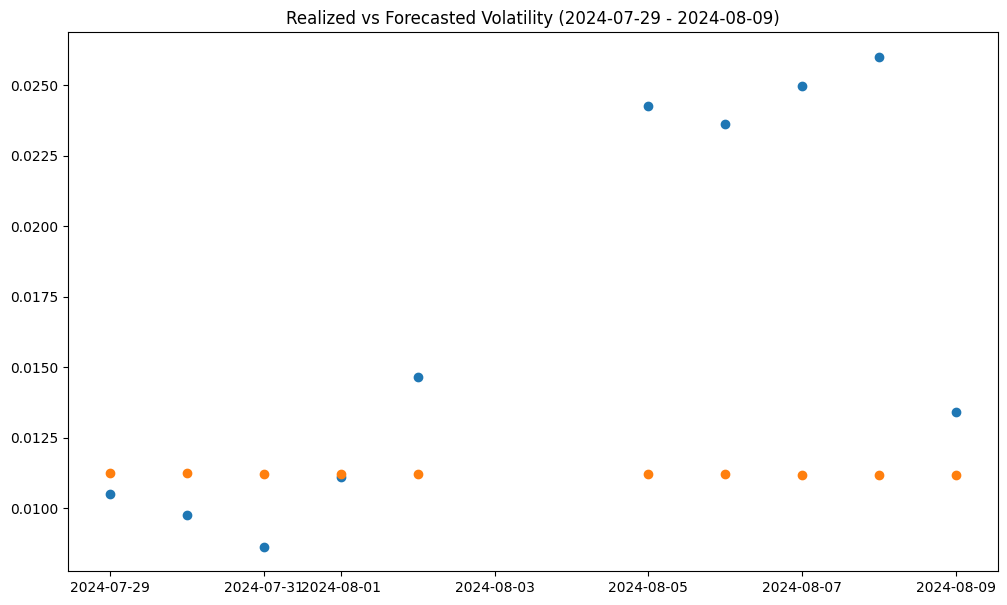

In [75]:
plt.figure(figsize=(12,7))
plt.title(f"Realized vs Forecasted Volatility ({str(result['Date'].iloc[0].date())} - {str(result['Date'].iloc[-1].date())})")
plt.scatter(x=result['Date'], y=result['YangZhangRealizedVolatilty'])
plt.scatter(x=result['Date'], y=result['ForecastedVolatility'])

In [76]:
from sklearn.metrics import root_mean_squared_error

print("RMSE =", root_mean_squared_error(result['YangZhangRealizedVolatilty'], result['ForecastedVolatility']))

RMSE = 0.008724047056046492


Given the RMSE, on average, the forecasted volatilities are off by about 0.87%. We can see from the graph that, it could not quite predict the jump in volatility during the start of Augusts for the sell-off in tech stocks. This could be due to $AR$-$GARCH$ model's assumption on linear relationship between past and current returns resulting in an inability to predict the sudden jump in volatility due to non-linear relationship.